In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

In [2]:
print("---Load and Explore Data---")
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
df.columns = ['label', 'message']

print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nGeneral info about the dataset:")
df.info()
print("\nLabel distribution: (spam/ham):")
print(df['label'].value_counts())
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
print("\nCreated numerical label column 'label_num'(0: ham, 1: spam).")

---Load and Explore Data---

First 5 rows of the dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

General info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Label distribution: (spam/ham):
label
ham     4825
spam     747
Name: count, dtype: int64

Created numerical label column 'label_num'(0: ham, 1: spam).


In [3]:
print("\n---Text Preprocessing---")
stopwords = set(stopwords.words('english')) #nltk stopwords: a, an, the, in, on, because, as, until, while, etc.

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    #keep a-z: letters; 0-9: numbers; \S: spaces
    text =re.sub(r'[^a-z\s]', '', text)
    # text =re.sub(r'[^a-z0-9\s]', '', text)
    
    words = text.split()
    
    # keep words longer than 1, 2 or 3 characters
    filtered_words = [word for word in words if word not in stopwords and len(word) > 2]
    
    return " ".join(filtered_words)

df['clean_message'] = df['message'].apply(preprocess_text)
print("Text preprocessing completed.")
print("\nOriginal: ", df['message'][0])
print("Processed: ", df['clean_message'][0])


---Text Preprocessing---
Text preprocessing completed.

Original:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed:  jurong point crazy available bugis great world buffet cine got amore wat


In [4]:
print("\n---Split Data---")
X = df['clean_message']
y = df['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples | Test set: {X_test.shape[0]} samples")


---Split Data---
Training set: 4457 samples | Test set: 1115 samples


In [5]:
print("\n---Text Vectorization---")

# Change Vectorizer technique
# 1. CountVectorizer: Bag of Words
# 2. TfidfVectorizer: TF-IDF: Term Frequency-Inverse Document Frequency (Tần số từ - Tầm quan trọng của từ trong tài liệu)
# tf = (Number of times term t appears in a document) / (Total number of terms in the document)
# idf = log_e(Total number of documents / Number of documents with term t in it)


# vectorizer = CountVectorizer(min_df=0.003, max_df=2000)

# vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer()

X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")
print(f"Training matrix shape: {X_train_vect.shape}")


---Text Vectorization---
Number of features: 7156
Training matrix shape: (4457, 7156)


In [6]:
print("\n---Model Training---")

# Change value smoothing parameters: 
# alpha=1.0 (Laplace smoothing), 
# alpha=0.5 (Lidstone smoothing), 
# alpha=0.1 (Less smoothing), 
# alpha=2.0 (More smoothing)

# Change algorithm Naive Bayes:
# BernoulliNB: suitable for binary/boolean features
# ComplementNB: suitable for imbalanced datasets

model = MultinomialNB(alpha=1.0)

model.fit(X_train_vect, y_train)
print("Model trained successfully.")


---Model Training---
Model trained successfully.



---Model Evaluation---
Accuracy: 0.9785
Precision: 0.9433
Recall: 0.8926
F1 Score: 0.9172

Confusion Matrix:


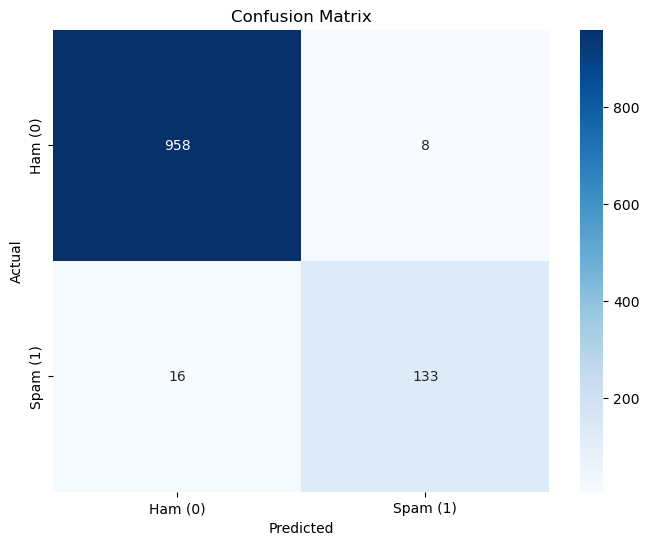


True Negatives (Correctly Ham): 958
False Positives (Ham -> Spam): 8
False Negatives (Spam -> Ham): 16
True Positives (Correctly Spam): 133


In [7]:
print("\n---Model Evaluation---")
y_pred = model.predict(X_test_vect)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham (0)', 'Spam (1)'], yticklabels=['Ham (0)', 'Spam (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Correctly Ham): {tn}")
print(f"False Positives (Ham -> Spam): {fp}")
print(f"False Negatives (Spam -> Ham): {fn}")       
print(f"True Positives (Correctly Spam): {tp}")